In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Image processing
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
import skimage
import skimage.io
import skimage.transform
import math
import time
from imageio import imread

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers.normalization import BatchNormalization
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import optimizers


#Pre-trained model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19 
from keras.applications.xception import Xception
from keras.applications.mobilenet import MobileNet
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.resnet50 import ResNet50
from keras.applications.nasnet import NASNetLarge
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras.utils import plot_model
from keras import Input

In [6]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split=0.25)

test_datagen = ImageDataGenerator(rescale = 1./255)
size=224
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/My_WorkSpace_2020/DATASET/',
                                                 target_size = (size, size),
                                                 batch_size = 32,
                                                 subset='training',
                                               #  class_mode='binary'
                                                 )

test_set = train_datagen.flow_from_directory('/content/drive/My Drive/My_WorkSpace_2020/DATASET/',
                                            target_size = (size, size),
                                            batch_size = 32,
                                            shuffle=False,
                                            subset='validation',
                                            #class_mode='binary'
                                            )

Found 1696 images belonging to 2 classes.
Found 564 images belonging to 2 classes.


In [7]:

baseModel = Xception(weights='imagenet', include_top=False, input_tensor=Input(shape=(size, size, 3)))
headModel = baseModel.output
headModel = Flatten(name = "flattern")(headModel)
headModel = Dense(512, activation = "relu")(headModel)  
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

83689472/83683744 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
___________________________

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
sgd = optimizers.SGD(lr=0.001, momentum=0.9) #0.001 -->89.02%
rms = optimizers.RMSprop(1e-5)  #0.001
adam = optimizers.Adam(lr=0.001) #learning_rate #0.001
model.compile(loss='binary_crossentropy',
              optimizer=rms,         #adam
              metrics=['accuracy'])
print('Compiled!')

Compiled!


In [0]:
def step_decay(epoch):
    initial_lrate = 0.1
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate
lrate = LearningRateScheduler(step_decay)

earlystopper1 = EarlyStopping(monitor='val_loss',mode = 'min', patience=7, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('/content/drive/My Drive/My_WorkSpace_2020/best_models/Xception/best_model_224_224_rms_25percent.h5'
                                ,monitor='val_accuracy' #'val_acc' for colab 
                                ,mode = 'max'
                                ,verbose=1
                                ,save_best_only=True
                                ,save_weights_only=True)

In [11]:
import time
starttime=time.time()
training=model.fit_generator(
        training_set,
        #steps_per_epoch=100,
        epochs=20,
        validation_data = test_set, 
        #validation_steps = 30,
        callbacks=[earlystopper1, checkpointer1],
        shuffle= True
       )

Exetime = time.time()-starttime
print("Seconds: ", Exetime)
local_time = time.gmtime(Exetime)
print("Execution Time: ",time.strftime(" %H:%M:%S", local_time))

Epoch 1/20
53/53 [==============================] - 738s 14s/step - loss: 0.4699 - accuracy: 0.7706 - val_loss: 1.6563 - val_accuracy: 0.5035

Epoch 00001: val_accuracy improved from -inf to 0.50355, saving model to /content/drive/My Drive/My_WorkSpace_2020/best_models/Xception/best_model_224_224_rms_25percent.h5
Epoch 2/20
53/53 [==============================] - 125s 2s/step - loss: 0.2657 - accuracy: 0.8921 - val_loss: 1.1986 - val_accuracy: 0.5408

Epoch 00002: val_accuracy improved from 0.50355 to 0.54078, saving model to /content/drive/My Drive/My_WorkSpace_2020/best_models/Xception/best_model_224_224_rms_25percent.h5
Epoch 3/20
53/53 [==============================] - 134s 3s/step - loss: 0.1783 - accuracy: 0.9281 - val_loss: 1.4459 - val_accuracy: 0.5833

Epoch 00003: val_accuracy improved from 0.54078 to 0.58333, saving model to /content/drive/My Drive/My_WorkSpace_2020/best_models/Xception/best_model_224_224_rms_25percent.h5
Epoch 4/20
53/53 [==============================] -

In [0]:
  #Loading Saved model
model.load_weights('/content/drive/My Drive/My_WorkSpace_2020/best_models/InceptionV3/best_model_224_224_rms_20percent.h5')
y_prob = model.predict(test_set) 

In [0]:
predicted = y_prob.argmax(axis=-1)
actual = test_set.classes
class_labels = test_set.class_indices
print(predicted)
print(actual)
print(class_labels)

[1 0 0 1 1 0 0 1 0 0 1 1 0 1 1 0 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 0 1 1 0 1 1
 0 0 0 1 1 1 0 0 0 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1
 1 0 0 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 1 1
 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1
 0 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 0 1 1 1 1 0 1 0
 0 0 1 1 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 0
 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1
 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 

In [0]:
#Accuracy calculation and confusion matrix generation

from numpy import argmax
import pandas as pd
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import seaborn as sn
import numpy as np
class_labels =['melanoma','non melanoma'] 
predicted = y_prob.argmax(axis=-1)
actual = test_set.classes
results = confusion_matrix(actual, predicted)
acc = accuracy_score(actual, predicted) 
report = classification_report(actual, predicted)

print(results) 
print ('Accuracy Score :',acc) 
print ('Report :', report)

[[ 85 154]
 [ 28 184]]
Accuracy Score : 0.5964523281596452
Report :               precision    recall  f1-score   support

           0       0.75      0.36      0.48       239
           1       0.54      0.87      0.67       212

    accuracy                           0.60       451
   macro avg       0.65      0.61      0.58       451
weighted avg       0.65      0.60      0.57       451



[[303  67]
 [  7 297]]
Accuracy Score : 0.8902077151335311
Report :               precision    recall  f1-score   support

           0       0.98      0.82      0.89       370
           1       0.82      0.98      0.89       304

    accuracy                           0.89       674
   macro avg       0.90      0.90      0.89       674
weighted avg       0.90      0.89      0.89       674

confmat.txt Done!!
report.txt Done!!


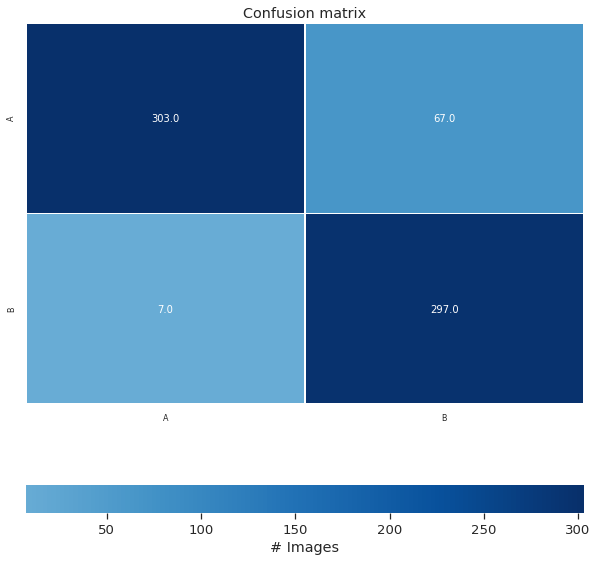

In [0]:
#Accuracy calculation and confusion matrix generation

from numpy import argmax
import pandas as pd
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report
import seaborn as sn
import numpy as np
class_labels =['A','B'] 
predicted = y_prob.argmax(axis=-1)
actual = test_set.classes
results = confusion_matrix(actual, predicted)
acc = accuracy_score(actual, predicted) 
report = classification_report(actual, predicted)

print(results) 
print ('Accuracy Score :',acc) 
print ('Report :', report)


#Confusion matrix txt file
result_json_file = '/content/drive/My Drive/My Work Space/Model_results/Xception_best_model/confmat_224_224_sgd89.txt' 
with open(result_json_file, mode='w') as f:
    print(results,file=f)
print("confmat.txt Done!!")

#Report txt file
report_json_file = '/content/drive/My Drive/My Work Space/Model_results/Xception_best_model/report_224_224_sgd89.txt' 
with open(report_json_file, mode='w') as f:
  f.write(report)
print("report.txt Done!!")

#Heat Map draw
sn.set(font_scale=1.2)
plt.figure(figsize = (10,10))
map = sn.heatmap(results, annot=True,annot_kws={"size": 10}, center=1,cmap="Blues", fmt='.1f',lw=0.7, cbar=True, cbar_kws={'label': '# Images', 'orientation': 'horizontal'})
map.set_title('Confusion matrix')
map.set_xticklabels(class_labels, fontsize = 8)
map.set_yticklabels(class_labels, fontsize = 8)
figure = map.get_figure()  
figure.savefig("/content/drive/My Drive/My Work Space/Model_results/Xception_best_model/Heat_map_224_224_sgd89.png")

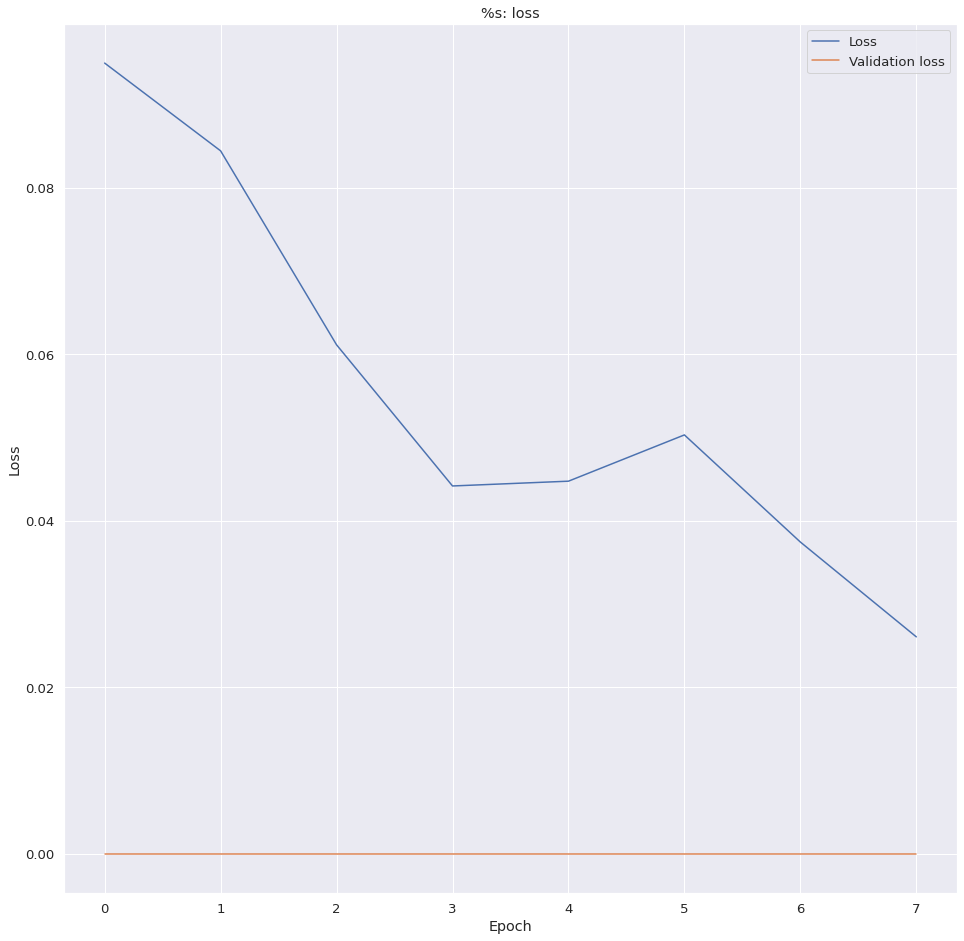

In [0]:
#plot loss
fig = plt.figure(figsize=(16, 16)) 
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(training.history['loss'], label="Loss")
plt.plot(training.history['val_loss'], label="Validation loss")
plt.title('%s: loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
fig.savefig("/content/drive/My Drive/My Work Space/Model_results/Xception_best_model/loss_plot_sgd89.png")

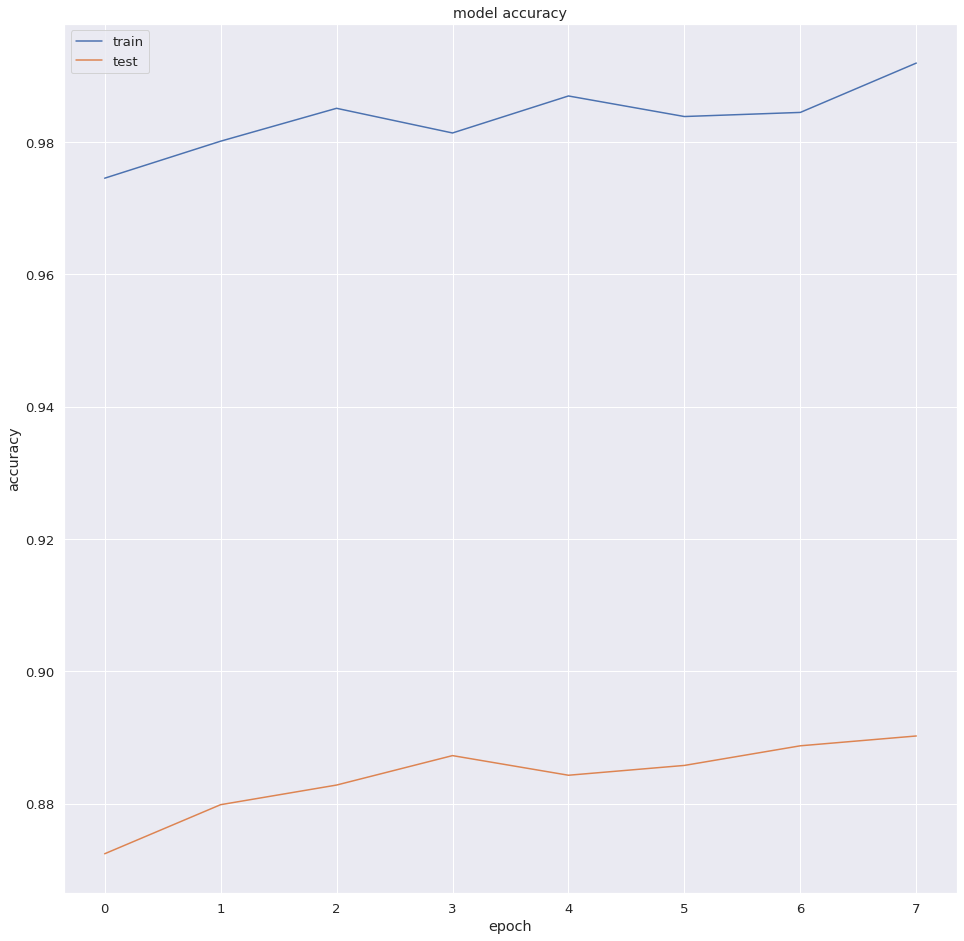

In [0]:
#plot model accuracy
fig1 = plt.figure(figsize=(16, 16)) 

plt.plot(training.history['accuracy'])
plt.plot(training.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig1.savefig("/content/drive/My Drive/My Work Space/Model_results/Xception_best_model/Accuracy_plot_224_224_sgd89.png")